In [27]:
import re 
import pandas as pd 
import numpy as np 
import get_data as gd 
import yaml as ym
from datetime import datetime
import nltk as nk 
import spacy as sp
from nltk.tag.stanford import StanfordNERTagger as st
import plotly.express as px


## Functions 

In [2]:
def words_in_all_articles(search_words, all_articles): 
    """
    Take a list of search words and find them in the dataframe of articles 
    where the dataframe contains a column called content which contains the 
    text of the article

    This returns a list containing indices of the articles where the search
    words are present and a list containing the text of the relevant articles 

    """
    articles= []
    for num in range(0, len(all_articles)):
        single_page = ""
        art_content = all_articles.iloc[num].content
        single_page = single_page.join(art_content)
        single_page = single_page.replace("\n", " ")

        in_count = 0

        for word in search_words: 
            if word in single_page: 
                in_count += 1

        if in_count > 0: 
            contains_list.append(num)
            articles.append(single_page.strip())
            
    return contains_list, articles


## Generate dataset


In [3]:
# importing the config file with its values 
with open("config.yaml", 'r') as yaml_file:
        config_file = ym.safe_load(yaml_file)

#location of data file 
file_loc = config_file["file_loc"]        

#months dictionary
months = config_file["months"]
months_list = list(months.keys())
        

In [4]:
# checking the number of available articles 
auth_datetime, url_data, content_data = gd.organize_data(file_loc)
print("auth_datetime_length {}" .format( len(auth_datetime)))


auth_datetime_length 2601


In [5]:
# isolating the datetime and author info
datetime_info = []
for x in auth_datetime: 
    auth_time_info = ""
    auth_time_info = auth_time_info.join(x)
    auth_time_info = auth_time_info.lower()
    datetime_obj = auth_time_info.split('updated:')[-1]
    datetime_info.append(datetime_obj)
    


In [6]:
# using datetime package to convert string date and time to datetime object
row = []
new_datetime_format = ["None" for _ in range(len(auth_datetime))]

for indx, dt in enumerate(datetime_info): 
        dt = dt.replace("ist", "").strip().replace(",","-").replace(" ", "")
        if dt:
            for x in months_list: 
                find_val = dt.find(x)
                if find_val != -1: 
                    dt = dt.replace(x,str(months[x])+'-')
                    dd = datetime.strptime(dt, '%m-%d-%Y-%H:%M')
                    new_datetime_format[indx] = dd
                    row.append(indx)

       

In [7]:
# parsing datetime object to get date time features
all_years = ["None" for _ in range(len(auth_datetime))]
all_days = ["None" for _ in range(len(auth_datetime))]
all_months = ["None" for _ in range(len(auth_datetime))]
all_hours =["None" for _ in range(len(auth_datetime))]
all_mins = ["None" for _ in range(len(auth_datetime))]

for indx, x in enumerate(new_datetime_format):
    if x != "None": 
        all_years[indx] = x.year
        all_days[indx] = x.day
        all_months[indx] = x.month
        all_hours[indx] = x.hour
        all_mins[indx] = x.minute

In [8]:
# generating a dataframe to store all the data 

all_data = {"auth_datetime": auth_datetime, 
            "url_data": url_data,
            "content": content_data,
            "year":all_years,
            "month": all_months,
            "day": all_days, 
            "hour": all_hours, 
            "minutes": all_mins}

all_data_df  = pd.DataFrame(data = all_data)
all_data_df.head(100)


,auth_datetime,url_data,content,year,month,day,hour,minutes
0,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[A , was arrested when , Rural police, on Th...",2019,5,25,5,0
1,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[Fourteen stolen , and , of Rs 82,000 face v...",2019,5,20,6,0
2,"[Bangalore Mirror Bureau , |, Updated: May 19...",https://bangaloremirror.indiatimes.com/bangalo...,"[Police nabbed two persons, who were seen acti...",2019,5,19,3,0
3,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[A man waiting for a bus was robbed at , by t...",2019,5,20,4,0
4,"[PTI , |, Updated: May 20, 2019, 18:09 IST]",https://bangaloremirror.indiatimes.com/bangalo...,"[ Two members of the notorious , were shot at...",2019,5,20,18,9
...,...,...,...,...,...,...,...,...
95,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, \n, (BoI) officials at the Kempegowda In...",2019,4,18,6,0
96,"[Bangalore Mirror Bureau , |, Updated: Apr 19...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, \n, After a three-year-old girl child was...",2019,4,19,6,0
97,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[The , International Airport police have arre...",2019,4,21,6,0
98,"[Bangalore Mirror Bureau , |, Updated: Apr 22...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, \n, I n a joint operation, Hosakote, Nand...",2019,4,22,6,0


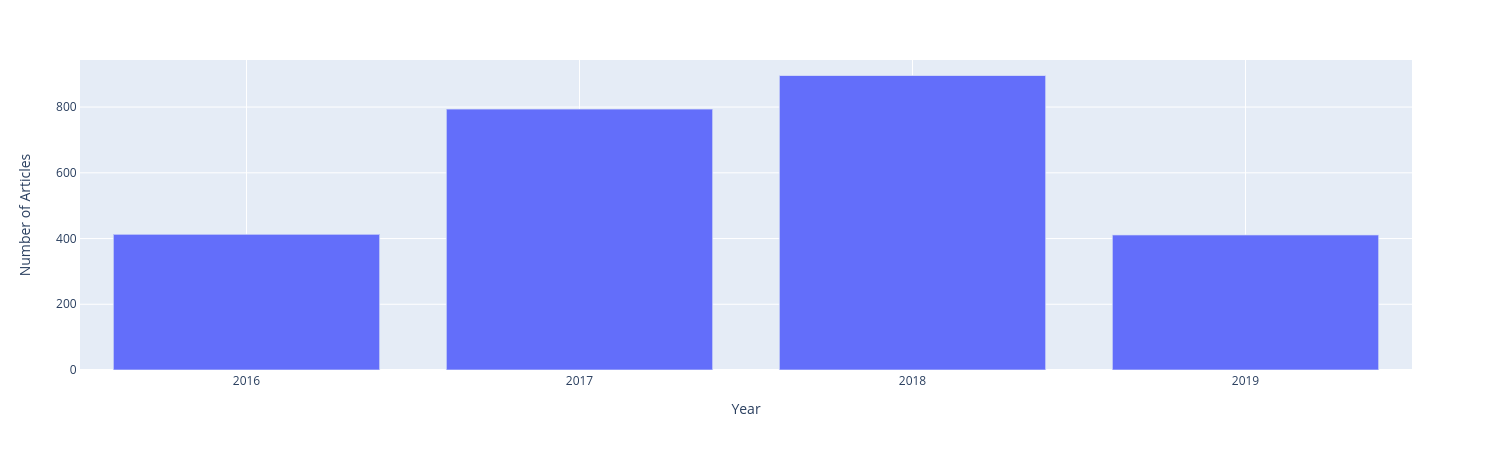

In [55]:
# checking how many years of data we have
articles_per_year = all_data_df.year.value_counts()
all_years = [2016,2017,2018,2019]
articles_per_year = articles_per_year.loc[all_years]
fig = px.bar(articles_per_year, x=articles_per_year.index, y=articles_per_year.values,)
fig.update_xaxes(type='category')
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Articles')
fig

## Find IPC codes and sections


In [10]:
contains_list =  []

search_words = ["section","IPC","Section"]

article_indices, articles_text = words_in_all_articles(search_words, all_data_df)



In [11]:
len(article_indices)

690

In [12]:
section_df = all_data_df.iloc[article_indices]

section_df

,auth_datetime,url_data,content,year,month,day,hour,minutes
1,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[Fourteen stolen , and , of Rs 82,000 face v...",2019,5,20,6,0
3,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[A man waiting for a bus was robbed at , by t...",2019,5,20,4,0
16,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, A 26-year-old auto driver has been arrest...",2019,5,18,6,0
17,"[Bangalore Mirror Bureau , |, Updated: May 17...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, \n, Just 25 days after his marriage, a 24...",2019,5,17,6,0
23,"[Bangalore Mirror Bureau , |, Updated: May 8,...",https://bangaloremirror.indiatimes.com/bangalo...,"[A 31-year-old driver was , by a group of men...",2019,5,8,6,0
...,...,...,...,...,...,...,...,...
2587,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[ \n, The city police have identified and arr...",2016,9,17,4,0
2589,"[Bangalore Mirror Bureau , |, Updated: Oct 6,...",https://bangaloremirror.indiatimes.com/bangalo...,[ Five were arrested for their alleged involve...,2016,10,6,4,0
2592,"[Bangalore Mirror Bureau , |, Updated: Sep 7,...",https://bangaloremirror.indiatimes.com/bangalo...,"[Pregnant, unmarried and abandoned by the boyf...",2016,9,7,2,0
2596,"[By , Chaitanya Swamy H M, Chaitanya Swamy H M...",https://bangaloremirror.indiatimes.com/bangalo...,"[ \n, \n, \n, \n, Two , were attacked and ...",2016,10,17,4,0


In [13]:
section_df

,auth_datetime,url_data,content,year,month,day,hour,minutes
1,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[Fourteen stolen , and , of Rs 82,000 face v...",2019,5,20,6,0
3,"[Bangalore Mirror Bureau , |, Updated: May 20...",https://bangaloremirror.indiatimes.com/bangalo...,"[A man waiting for a bus was robbed at , by t...",2019,5,20,4,0
16,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, A 26-year-old auto driver has been arrest...",2019,5,18,6,0
17,"[Bangalore Mirror Bureau , |, Updated: May 17...",https://bangaloremirror.indiatimes.com/bangalo...,"[\n, \n, Just 25 days after his marriage, a 24...",2019,5,17,6,0
23,"[Bangalore Mirror Bureau , |, Updated: May 8,...",https://bangaloremirror.indiatimes.com/bangalo...,"[A 31-year-old driver was , by a group of men...",2019,5,8,6,0
...,...,...,...,...,...,...,...,...
2587,"[By , Praveen Kumar, Praveen Kumar, , Bangalor...",https://bangaloremirror.indiatimes.com/bangalo...,"[ \n, The city police have identified and arr...",2016,9,17,4,0
2589,"[Bangalore Mirror Bureau , |, Updated: Oct 6,...",https://bangaloremirror.indiatimes.com/bangalo...,[ Five were arrested for their alleged involve...,2016,10,6,4,0
2592,"[Bangalore Mirror Bureau , |, Updated: Sep 7,...",https://bangaloremirror.indiatimes.com/bangalo...,"[Pregnant, unmarried and abandoned by the boyf...",2016,9,7,2,0
2596,"[By , Chaitanya Swamy H M, Chaitanya Swamy H M...",https://bangaloremirror.indiatimes.com/bangalo...,"[ \n, \n, \n, \n, Two , were attacked and ...",2016,10,17,4,0


### Print sentences with search words in them 


In [14]:



articles_df =section_df
for num in range(0, len(articles_df)): 
    relevant_sentences= []
    
    single_page =""
    art_content = articles_df.iloc[num].content
    single_page =  single_page.join(art_content)
    single_page = single_page.replace("\n"," ").strip()
    sentences = nk.sent_tokenize(single_page)


    for sent in sentences:
        for word in search_words: 
            if word in sent: 
                relevant_sentences.append(sent)
    
    data = {'sentences': relevant_sentences, 
                'sentence_index': [num for x in range(len(relevant_sentences)) ]}

    if num == 0: 
        relevant_sentences_df = pd.DataFrame(data= data)
    else: 
        relevant_sentences_df.append(data, ignore_index = True)
        


In [15]:
relevant_sentences_df

,sentences,sentence_index
0,Shaikh was booked under IPC sections 489B (usi...,0
1,Shaikh was booked under IPC sections 489B (usi...,0


In [16]:
len(articles_df)

690

In [17]:
data

{'sentences': ['Pasha has been booked under the POCSO Act for sexual harassment and use of a child for pornographic purposes and IPC Section 354 (D) for stalking, and sent to judicial custody.',
  'Pasha has been booked under the POCSO Act for sexual harassment and use of a child for pornographic purposes and IPC Section 354 (D) for stalking, and sent to judicial custody.'],
 'sentence_index': [689, 689]}

## Test extracting locations


In [18]:
single_page =""
re = all_data_df.iloc[num].content
single_page =  single_page.join(all_data_df.iloc[18].content)
single_page = single_page.replace("\n"," ").strip()
single_page

'By Pragna L Krupa  Sneaky sneakers aka thieves with a fetish for  have struck again in the city — this time in a residential area in Vasanthnagar. The thief has decamped with multiple pairs of branded shoes like , ,  and Skechers; all told the shoes were worth Rs 35,000.   Two Vasanthnagar residents have now filed a complaint with the High Grounds police. The thief has been caught on camera stealing the shoes during the night.   The complainant, Ajith Suran, said that on Saturday he had kept his shoes along with the box outside the house in the shoe rack; on Sunday morning he noticed that two of his new shoes, Nike and , were missing from the rack. He said after checking the CCTV footage he learnt that a thief had stolen them.   While narrating the story to his friend, L Radha Krishna Raj, who resides in the same area, Suran realised that four pairs of shoes had been stolen from his house too last month. Suran told  Mirror that four pairs of Nike, Adidas and Bata went missing from the

In [19]:
nk.pos_tag(nk.word_tokenize(nk.sent_tokenize(single_page)[2]))

[('Two', 'CD'),
 ('Vasanthnagar', 'NNP'),
 ('residents', 'NNS'),
 ('have', 'VBP'),
 ('now', 'RB'),
 ('filed', 'VBN'),
 ('a', 'DT'),
 ('complaint', 'NN'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('High', 'NNP'),
 ('Grounds', 'NNP'),
 ('police', 'NNS'),
 ('.', '.')]

In [20]:
np.ones([10,1])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [21]:
# string_value ="The victim has been identified as Murthy N, 28, a resident of KR Puram, who works at a private company as a driver. His brother, Somashekar, told  Mirror that on Saturday evening when Murthy was on his way to deliver a customer's car around 6 pm, a bike hit the car’s bumper from behind on Kodichikkanahalli Main Road in Bilekahalli."
# tagged = nk.word_tokenize(string_value)

In [22]:
# from nltk.tag import StanfordNERTagger


In [23]:
# stanford_classifier = 'D:/Data_science/nltk_stanford/stanford-ner-2015-12-09/classifiers/english.all.3class.distsim.crf.ser.gz'
# stanford_ner_path = 'D:/Data_science/nltk_stanford/stanford-ner-2015-12-09/stanford-ner.jar'

In [24]:
# st = StanfordNERTagger(stanford_classifier, stanford_ner_path, encoding='utf-8')


In [25]:
# import os
# java_path = "C:/Program Files/Java/jdk-12.0.1/bin"
# os.environ['JAVAHOME'] = java_path

# text = 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

# # tokenized_text = nk.word_tokenize(string_val)
# classified_text = st.tag(tagged)


In [26]:
# nlp = sp.load("en_core_web_sm")
